<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Описание данных

 Признаки

-	RowNumber — индекс строки в данных
-	CustomerId — уникальный идентификатор клиента
-	Surname — фамилия
-	CreditScore — кредитный рейтинг
-	Geography — страна проживания
-	Gender — пол
-	Age — возраст
-	Tenure — сколько лет человек является клиентом банка
-	Balance — баланс на счёте
-	NumOfProducts — количество продуктов банка, используемых клиентом
-	HasCrCard — наличие кредитной карты
-	IsActiveMember — активность клиента
-	EstimatedSalary — предполагаемая зарплата

Целевой признак

-	Exited — факт ухода клиента


## Подготовка данных

Импорт всех необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Открываем предоставленный датасет и изучим информацию о данных


In [2]:
bank_client = pd.read_csv('/datasets/Churn.csv')
bank_client.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Получим статистические данные по датасету

In [3]:
bank_client.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Получим общую информацию по датасету

In [4]:
bank_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Проверим датасет на наличие дубликатов

In [5]:
print('Количество дубликатов:' ,bank_client.duplicated().sum())

Количество дубликатов: 0


Уберем первые три столбца - они нам не понадобятся

In [6]:
bank_client = bank_client.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
bank_client.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Переведем столбец Tenure в целочисленный формат

In [7]:
bank_client['Tenure'] = bank_client['Tenure'].astype('Int64')
bank_client['Tenure'] = bank_client['Tenure'].fillna(bank_client['Tenure'].median())
bank_client['Tenure'].isnull().sum()

0

Переведем названия столбцов в нижний регистр

In [8]:
bank_client.columns = bank_client.columns.str.lower()
bank_client.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

## Исследование задачи

Рассчитаем долю объектов положительного класса

In [9]:
bank_client['exited'].mean()

0.2037

Рассчитаем долю объектов отрицательного класса

In [10]:
1 - bank_client['exited'].mean()

0.7963

Как мы видим из нашего расчета доля отрицательного класса намного больше

Для удобства дальнейшего использования разобьем данные по дамми-значениям и переведем столбец gender в численный формат

In [11]:
bank_client['gender'] = pd.get_dummies(bank_client['gender'], drop_first=True)
bank_client_ohe = pd.get_dummies(bank_client['geography'])
bank_client['france_user'] = bank_client_ohe['France']
bank_client['germany_user'] = bank_client_ohe['Germany']
bank_client['spain_user'] = bank_client_ohe['Spain']

Разделим предоставленные данные на обучающую, тестовуюи валидационную выборки в пропорции 3:1:1

In [12]:
features = bank_client.drop(['exited','geography'], axis=1)
target = bank_client['exited']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size = 0.5, random_state=12345)
print('Обучающая выборка:', features_train.shape)
print(target_train.shape)
print('Валидационная выборка:', features_valid.shape)
print(target_valid.shape)
print('Тестовая выборка:', features_test.shape)
print(target_test.shape)

Обучающая выборка: (6000, 12)
(6000,)
Валидационная выборка: (2000, 12)
(2000,)
Тестовая выборка: (2000, 12)
(2000,)


Обучим модель методом DecisionTreeClassifier (Дерево Решений)

In [13]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid) 
    result = mean_squared_error(target_valid, predicted_valid) ** 0.5 
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
print(best_result)

0.39749213828703583


In [14]:
print('Матрица ошибок:', confusion_matrix(target_valid, predicted_valid))
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Точность:', precision_score(target_valid, predicted_valid))
print( 'F1 мера:', f1_score(predicted_valid, target_valid))

Матрица ошибок: [[1525   52]
 [ 264  159]]
Полнота: 0.375886524822695
Точность: 0.7535545023696683
F1 мера: 0.5015772870662459


Обучим модель методом LogisticRegression

In [15]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 мера:', f1_score(target_valid, predicted_valid))

F1 мера: 0.13441955193482688


## Борьба с дисбалансом

Напишем функцию, используя Upsampling(от англ. up, «вверх»; sampling, «выборка»), обучим модели с помощью новых данных и узнаем F1

In [16]:
def checkstat (model, features, target): 
    model.fit(features, target)
    predicted_valid=model.predict(features_valid)
    print("F1:", f1_score(target_valid, predicted_valid))
    print(recall_score(target_valid, predicted_valid))
    print(precision_score(target_valid, predicted_valid))

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model_lr = LogisticRegression(random_state=12345, solver = 'liblinear')
checkstat(model_lr, features_upsampled, target_upsampled)

model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=5)
checkstat(model_dtc, features_upsampled, target_upsampled)

model_rfc = RandomForestClassifier(random_state=12345, n_estimators=71, max_depth=5, class_weight='balanced')
checkstat(model_rfc, features_upsampled, target_upsampled)


F1: 0.3741814780168382
0.9456264775413712
0.23323615160349853
F1: 0.520471894517696
0.8865248226950354
0.36836935166994106
F1: 0.6021934197407777
0.7139479905437353
0.5206896551724138


По примеру предыдущей функции напишем функцию, используя Downsampling(от англ. down, «вниз»; sampling, «выборка»), обучим модели с помощью новых данных и узнаем F1

In [18]:
def downsample(features,target, fraction):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones= target[target==1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled= shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model_lr = LogisticRegression(random_state=12345, solver='liblinear')
checkstat(model_lr,features_downsampled, target_downsampled)

model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=5)
checkstat(model_dtc, features_downsampled, target_downsampled)

model_rfc = RandomForestClassifier(random_state=12345, n_estimators=71, max_depth=5, class_weight='balanced')
checkstat(model_rfc, features_downsampled, target_downsampled)

F1: 0.37337057728119183
0.9479905437352246
0.23246376811594202
F1: 0.5112168592794017
0.8888888888888888
0.35877862595419846
F1: 0.5485008818342151
0.735224586288416
0.43741209563994377


Переберём значения порогов от 0 до 0.9 с шагом 0.02. Найдём для каждого значения точность и полноту. Напечатаем результаты на экране 

In [19]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid) 
    f1=f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.211, Полнота = 1.000, F1 = 0.349154
Порог = 0.02 | Точность = 0.211, Полнота = 1.000, F1 = 0.349154
Порог = 0.04 | Точность = 0.212, Полнота = 1.000, F1 = 0.350021
Порог = 0.06 | Точность = 0.216, Полнота = 0.991, F1 = 0.354484
Порог = 0.08 | Точность = 0.222, Полнота = 0.969, F1 = 0.361712
Порог = 0.10 | Точность = 0.231, Полнота = 0.917, F1 = 0.368471
Порог = 0.12 | Точность = 0.243, Полнота = 0.865, F1 = 0.379275
Порог = 0.14 | Точность = 0.255, Полнота = 0.809, F1 = 0.387535
Порог = 0.16 | Точность = 0.259, Полнота = 0.735, F1 = 0.383005
Порог = 0.18 | Точность = 0.272, Полнота = 0.652, F1 = 0.383600
Порог = 0.20 | Точность = 0.285, Полнота = 0.596, F1 = 0.385911
Порог = 0.22 | Точность = 0.300, Полнота = 0.539, F1 = 0.385787
Порог = 0.24 | Точность = 0.310, Полнота = 0.473, F1 = 0.374532
Порог = 0.26 | Точность = 0.316, Полнота = 0.409, F1 = 0.356701
Порог = 0.28 | Точность = 0.343, Полнота = 0.374, F1 = 0.357871
Порог = 0.30 | Точность = 0.354, Полнота

Как мы видим лучший показатель F1 при пороге 0.20.

Построем Roc-кривую и визуализируем ее

Text(0.5, 1.0, 'ROC-кривая')

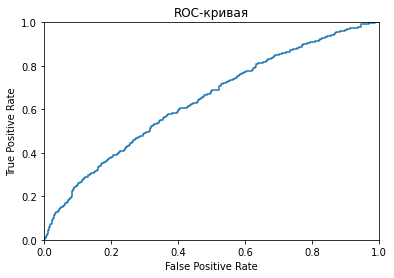

In [20]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC-кривая")

Используя различные модели(DecisiontreeClassifier, RandomForestClassifier и LogisticRegression) найдем лучший результат и определим лучшую для расчета модель

In [21]:
def proby (model, threshold=0.20):
    threshold = 0.20
    prob = []
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:,1]
    for probab in probabilities_one_valid:
        if probab > threshold:
            prob.append(1)
        else:
            prob.append(0)
    return prob

DecisionTreeClassifier (Дерево решений)

In [22]:
model_dtr = DecisionTreeClassifier(random_state=12345)
best_model = None
best_result = 3214
best_leaf = 0
best_depth = 5
best_split = 2

for split in range(3, 11):
    for leaf in range(1, 11):
        for depth in range (1, 15):
            model_dtr = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf, min_samples_split= split)
            model_dtr.fit(features_train, target_train) 
            predictions_valid = model_dtr.predict(features_valid) 
            movedts_valid=proby(model_dtr, threshold)
            result = model_dtr.score(features_valid, movedts_valid) 
            probabilities_valid = model_dtr.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            if result < best_result:
                best_model = model_dtr
                best_result = result
                best_leaf = leaf
                best_depth = depth
                best_split=split
print("Точность наилучшей модели на валидационной выборке:", best_result, 
      "минимум значений в листе:", best_leaf, "Максимальная глубина:", depth, "лучшее разделение:", best_split, 'ROC-AUC:',auc_roc)

Точность наилучшей модели на валидационной выборке: 0.7065 минимум значений в листе: 1 Максимальная глубина: 14 лучшее разделение: 3 ROC-AUC: 0.7993564403189466


In [23]:
for est in range(1, 101, 10):
    for depth in range (1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_valid, target_valid) 
        predictions_valid = model.predict(features_valid)
        movedts_valid=proby(model, 0.20)
        result = model.score(features_valid, movedts_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("Точность наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", depth, 'ROC-AUC:',auc_roc)

Точность наилучшей модели на валидационной выборке: 0.989 Количество деревьев: 1 Максимальная глубина: 14 ROC-AUC: 0.9999970018183971


In [24]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear') 
model_lr.fit(features_train, target_train)
movedts_valid=proby(model_lr, 0.20)
result = model.score(features_valid, movedts_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("Точность модели на валидационной выборке:", result, 'ROC-AUC:',auc_roc)

Точность модели на валидационной выборке: 0.6005 ROC-AUC: 0.9999970018183971


Вывод - метод случайного леса показывает наилучший результат по сравнению с другими моделями

## Тестирование модели

Лучший показатель показал метод Случайного леса

In [25]:
model_test = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
model_test.fit(features_test, target_test)
predictions_test = model_test.predict(features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test


0.997

Тестирование модели показало, что модель способна правильно предсказать около 99% ответов

# Вывод

В данной работе проделали следующие шаги:
- открывали предоставленный датасет и изучили информацию о данных (получили статистические данные, общую информацию по датасету, проверили датасет на наличие дубликатов)
- перевели названия столбцов в нижний регистр
- рассчитали долю объектов положительного и отрицательных классов и выяснили, что доля отрицательного класса в 4 раза больше
- разделили предоставленные данные на обучающую, тестовуюи валидационную выборки в пропорции 3:1:1
- провели работу по борьбе с дисбалансом (написали функцию, используя Upsampling и Downsampling, обучили модели с помощью новых данных и узнали F1, перебрали значения порогов от 0 до 0.9 с шагом 0.02 и нашли для каждого значения точность и полноту, выяснили, что лучший показатель F1 при пороге 0.20, построили Roc-кривую, используя различные модели(DecisiontreeClassifier, RandomForestClassifier и LogisticRegression) нашли лучший результат и определили лучшую для расчета модель
- при тестировании модели выяснили, что модель может предсказать 99% ответов